# Нейронная сеть для классификации стоимости автомобилей

Эпоха 0, Потери: 0.6932, Точность на обучении: 0.4860
Эпоха 200, Потери: 0.6932, Точность на обучении: 0.4890
Эпоха 400, Потери: 0.6932, Точность на обучении: 0.4885
Эпоха 600, Потери: 0.6932, Точность на обучении: 0.4915
Эпоха 800, Потери: 0.6932, Точность на обучении: 0.4945
Эпоха 1000, Потери: 0.6932, Точность на обучении: 0.4970
Эпоха 1200, Потери: 0.6932, Точность на обучении: 0.4980
Эпоха 1400, Потери: 0.6932, Точность на обучении: 0.5005
Эпоха 1600, Потери: 0.6932, Точность на обучении: 0.5015
Эпоха 1800, Потери: 0.6932, Точность на обучении: 0.5005
Эпоха 2000, Потери: 0.6932, Точность на обучении: 0.5015
Эпоха 2200, Потери: 0.6932, Точность на обучении: 0.5015
Эпоха 2400, Потери: 0.6932, Точность на обучении: 0.5020
Эпоха 2600, Потери: 0.6932, Точность на обучении: 0.5025
Эпоха 2800, Потери: 0.6932, Точность на обучении: 0.5045

Метрики на тестовом наборе:
Accuracy: 0.5020
Precision: 0.5235
Recall: 0.6326
F1: 0.5729

Матрица путаницы на тестовом наборе:
[[ 84 152]
 [ 97 167]]


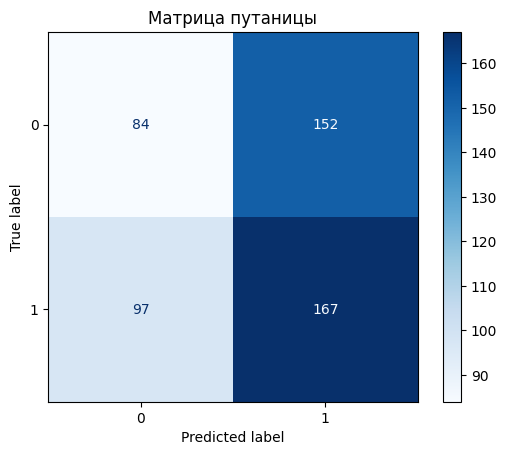

In [35]:
# -- Начало классов для независимости ячейки --
import torch
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score, accuracy_score, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Класс для полносвязного слоя
class Dense:
  def __init__(self, n_inputs, n_neurons):
    self.weights = torch.randn(n_inputs, n_neurons, requires_grad=False) * 0.01
    self.biases = torch.zeros(n_neurons, requires_grad=False)

  def forward(self, inputs):
    self.inputs = inputs
    self.output = self.inputs @ self.weights + self.biases
    return self.output

  def backward(self, dvalues):
    with torch.no_grad():
        self.dweights = self.inputs.T @ dvalues
        self.dbiases = torch.sum(dvalues, dim=0)
        self.dinputs = dvalues @ self.weights.T

# Класс для функции активации ReLU
class Activation_ReLU:
  def forward(self, inputs):
    self.inputs = inputs
    self.output = inputs.clip(min=0)
    return self.output

  def backward(self, dvalues):
    with torch.no_grad():
        self.dinputs = dvalues.clone()
        self.dinputs[self.inputs <= 0] = 0

# --- ОБЪЕДИНЕННЫЙ КЛАСС АКТИВАЦИИ И ПОТЕРЬ ---
class Activation_Sigmoid_BCE_Loss:
    def forward(self, inputs, y_true):
        self.output = 1 / (1 + torch.exp(-inputs))
        y_pred_clipped = torch.clamp(self.output, 1e-7, 1 - 1e-7)
        sample_losses = -(y_true * torch.log(y_pred_clipped) + (1 - y_true) * torch.log(1 - y_pred_clipped))
        return sample_losses.mean()

    def backward(self, y_pred, y_true):
        with torch.no_grad():
            samples = len(y_pred)
            outputs = y_pred.shape[1] if len(y_pred.shape) > 1 else 1
            self.dinputs = (y_pred - y_true) / outputs
            self.dinputs = self.dinputs / samples

# -- Конец секции классов --

# 1. Загрузка и подготовка данных
df = pd.read_csv('car_price_prediction_.csv')
df['price_binary'] = (df['Price'] >= 50000).astype('int')
numerical_features = ['Year', 'Engine Size', 'Mileage']
categorical_features = ['Brand', 'Fuel Type', 'Transmission', 'Condition', 'Model']
df_processed = pd.get_dummies(df, columns=categorical_features, drop_first=True, dtype=float)
y = df_processed['price_binary']
X = df_processed.drop(['Car ID', 'Price', 'price_binary'], axis=1)

# --- КЛЮЧЕВОЕ ИСПРАВЛЕНИЕ ---
# Приводим ВСЕ признаки к единому типу float32 ДО разделения и масштабирования
X = X.astype(np.float32)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

scaler = StandardScaler()
X_train[numerical_features] = scaler.fit_transform(X_train[numerical_features])
X_test[numerical_features] = scaler.transform(X_test[numerical_features])

# Теперь преобразование в тензоры будет работать без проблем с типами
X_train_tensor = torch.from_numpy(X_train.values).to(dtype=torch.float32)
y_train_tensor = torch.from_numpy(y_train.values).to(dtype=torch.float32).view(-1, 1)
X_test_tensor = torch.from_numpy(X_test.values).to(dtype=torch.float32)
y_test_tensor = torch.from_numpy(y_test.values).to(dtype=torch.float32).view(-1, 1)

# 2. Создание и обучение нейронной сети
n_inputs = X_train_tensor.shape[1]
n_hidden_neurons = 64
n_outputs = 1

fc1 = Dense(n_inputs, n_hidden_neurons)
relu1 = Activation_ReLU()
fc2 = Dense(n_hidden_neurons, n_outputs)

sigmoid_bce_loss = Activation_Sigmoid_BCE_Loss()

lr = 0.000005 # Можно попробовать увеличить lr после исправления данных
epochs = 3000 # Увеличим эпохи для надежности

for epoch in __builtins__.range(epochs):
    # Прямой проход
    out1 = fc1.forward(X_train_tensor)
    out_relu = relu1.forward(out1)
    out2 = fc2.forward(out_relu)

    data_loss = sigmoid_bce_loss.forward(out2, y_train_tensor)

    if epoch % 200 == 0:
        # Также посчитаем точность на обучающей выборке, чтобы видеть динамику
        predictions_train = (sigmoid_bce_loss.output > 0.5).float()
        accuracy_train = accuracy_score(y_train_tensor.numpy(), predictions_train.numpy())
        print(f'Эпоха {epoch}, Потери: {data_loss.item():.4f}, Точность на обучении: {accuracy_train:.4f}')

    # Обратный проход
    sigmoid_bce_loss.backward(sigmoid_bce_loss.output, y_train_tensor)
    fc2.backward(sigmoid_bce_loss.dinputs)
    relu1.backward(fc2.dinputs)
    fc1.backward(relu1.dinputs)

    # Обновление весов
    fc1.weights -= lr * fc1.dweights
    fc1.biases -= lr * fc1.dbiases
    fc2.weights -= lr * fc2.dweights
    fc2.biases -= lr * fc2.dbiases

# 3. Оценка модели
out1_test = fc1.forward(X_test_tensor)
out_relu_test = relu1.forward(out1_test)
out2_test = fc2.forward(out_relu_test)
output_test = 1 / (1 + torch.exp(-out2_test))
predictions = (output_test > 0.5).float()

y_test_numpy = y_test_tensor.cpu().numpy()
predictions_numpy = predictions.cpu().numpy()

# Метрики
accuracy = accuracy_score(y_test_numpy, predictions_numpy)
precision = precision_score(y_test_numpy, predictions_numpy, zero_division=0)
recall = recall_score(y_test_numpy, predictions_numpy, zero_division=0)
f1 = f1_score(y_test_numpy, predictions_numpy, zero_division=0)

print("\nМетрики на тестовом наборе:")
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1: {f1:.4f}")

# Матрица путаницы
cm = confusion_matrix(y_test_numpy, predictions_numpy)
print("\nМатрица путаницы на тестовом наборе:")
print(cm)

disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap=plt.cm.Blues)
plt.title("Матрица путаницы")
plt.show()
